In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore') #ignore warnings

## Load mnist data using sci-kit learn

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
data, label = mnist['data'], mnist['target']
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
print(type(data))
label[:10]

<class 'pandas.core.frame.DataFrame'>


0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Note that labels a in form of string not a numeric values

Let's look at the size of data and target

In [5]:
print(data.shape)
print(label.shape)

(70000, 784)
(70000,)


The dataset consist of 70000 images and each image has 784 features, of hand written digit with size of 28x28 -- features are flatten

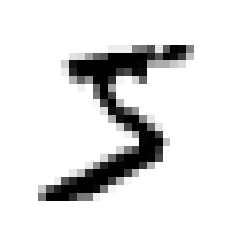

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_digit = data.iloc[0].to_numpy() # data series not allow reshape
sample_digit_image = sample_digit.reshape(28, 28)
plt.imshow(sample_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()


Labels are in type of string so convert it into integers

In [7]:
label = label.astype(np.uint8)
label[:10]

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: uint8

Let split the data set into train and test sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        data, 
        label, 
        test_size=0.14, 
        shuffle=True)

# Binary classification

Try to identify one digit (1 vs all) - convert problem into binary classification

In [9]:
# filter pandas label series by masking and convert it for binary classification

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

y_train_5.value_counts()

False    54784
True      5415
Name: class, dtype: int64

Out of 60199 images, 5408 hand written images are labelled as 5 - (less than 9%)

## let try with SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier()

In [11]:
sgd_classifier.predict([data.loc[0]])

array([ True])

## Measure accuracy using cross validation

In [12]:
from sklearn.model_selection import cross_val_score #kfold cross validation
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96342253, 0.96805542, 0.96072959])

Overall accuracy is good but try to classify non-5 class

In [13]:
from sklearn.base import BaseEstimator

class Non_5_classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
non_5_classifier = Non_5_classifier()
cross_val_score(non_5_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91104799, 0.9090003 , 0.91009668])

This different is due to only 10% of training set are number 5

## Measure accuracy using Confusion matrix

In [15]:
# to use confusion matrix we need actual prediction
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

### Confusion matrix

confusion matrix help us to measure performance of skewed class

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53292,  1492],
       [  959,  4456]])

false postives - 592 (non 5's are classified as 5)

false negative - 1661 (5's are classified as non-5) 

to improve our model we try to reduce these values

Row represent the actual class and column represent the predicted class

## Precision and Recall - best for skwed classes

In [17]:
# precision and recall 
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7491593813046402
0.8228993536472761


In [18]:
# f1 score - single number evaluation metric (combination of precision and recall)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7842999207955644

## Trade-off between precision and recall

Changing threshold based on precision and recall is way to imporve model perfomance

We can use precision_recall_curve or pricision vs recall to pick a value for threshold

let's visualize precision vs recall and determine threshold value

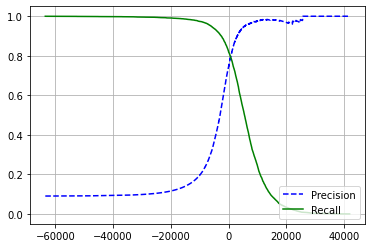

In [29]:
from sklearn.metrics import precision_recall_curve

# using decision_function method we can get an array of score
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3,
    method="decision_function") 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc='lower right')
plt.grid('true')
plt.show()

So, we need to find the lowest threshold which give highest precision and recall scores

Other way is Precision vs Recall

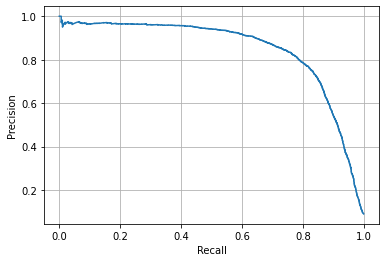

In [28]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('true')
plt.show()

Precision really starts to fall sharply around 80% recall. We will probably want to select a precision/recall tradeoff just before that drop.

In [30]:
# the lowest threshold which give 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

2994.7128378347634

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9001239157372987
0.6707294552169898


## Comparing models using ROC and AUC

Instead of predict actual values predict decision scores for each instance using cross_val_predict

In [19]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')

ROC curve is best for binary classification, it plots the true positive rate 
(another name for recall) against the false positive rate

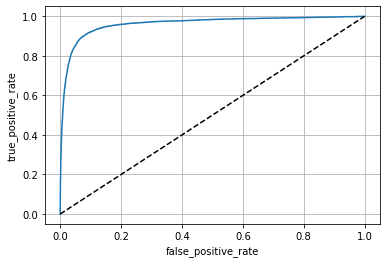

In [20]:
from sklearn.metrics import roc_curve
false_postive_rate, true_positive_rate, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(false_postive_rate, true_positive_rate)
plt.plot([0,1], [0,1], 'k--') # diagonal
plt.xlabel('false_positive_rate')
plt.ylabel('true_positive_rate')
plt.grid(True)
plt.show()

The good classifier stays as far from the diagonal line (toward the top-left corner)

We can use area under the curve (AUC) to calculate accurate value rather than visual

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96156455086468

## Let train with RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier()

# we can't call decision_funtion for forest classifier but instead we can use predic_prob
y_prob = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3, 
    method='predict_proba')
# since the predict_proba method return row for each instance and column for each class    
y_prob = y_prob[:, 1]
print(y_prob[:5])

[0.02 0.   0.96 0.   0.  ]


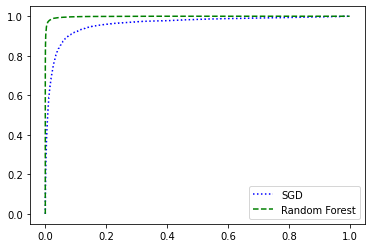

In [23]:
# comparing roc curves
false_postive_rate_forest, true_positive_rate_forest, thresholds_forest = roc_curve(y_train_5, y_prob)
plt.plot(false_postive_rate, true_positive_rate, 'b:', label='SGD')
plt.plot(false_postive_rate_forest, true_positive_rate_forest, 'g--', label='Random Forest')
plt.legend(loc='lower right')
plt.show()

let compute the AUC

In [24]:
roc_auc_score(y_train_5, y_prob)

0.9984827612755758

Try to measure precision and recall score

In [25]:
y_train_pred_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9921940928270042
0.8685133887349954


# Multiclass classification